# Расчёт размера выборки

In [1]:
import pandahouse as ph
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt


#  создаём генератор псевдослучайных чисел
rng = np.random.default_rng()

In [2]:
#  коннект к базе данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Для начала вытащим данные по просмотрам и CTR за период АА-теста и подготовим их нужным образом.

In [3]:
#  эмпирическое распределение просмотров

q = '''
SELECT views, count() users
FROM
(
    SELECT user_id, sum(action = 'view') views
    FROM simulator_20241120.feed_actions
    WHERE toDate(time) BETWEEN '2024-10-18' and '2024-10-24'
    GROUP BY user_id
)
GROUP BY views
ORDER BY views
'''


views_distribution = ph.read_clickhouse(q, connection=connection)
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.head()

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119
4,5,18,0.000429


In [4]:
#  эмпирическое распределение CTR 
q = """
SELECT floor(ctr, 2) as ctr, 
    count() as users
FROM 
(
    SELECT toDate(time) as dt, 
        user_id,
        sum(action = 'like')/sum(action = 'view') as ctr
    FROM simulator_20241120.feed_actions
    WHERE toDate(time) BETWEEN '2024-10-18' and '2024-10-24'
    GROUP BY dt, user_id
)
GROUP BY ctr
"""

ctr_distribution = ph.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.head()

,ctr,users,p
0,0.00,1443,0.016952
1,0.65,4,0.000047
2,0.71,5,0.000059
3,0.49,4,0.000047
4,0.54,72,0.000846


In [5]:
#  сколько пользователей было в АА-тесте
q = """
SELECT uniqExact(user_id)
FROM simulator_20241120.feed_actions
WHERE toDate(time) between '2024-10-18' and '2024-10-24'

"""

n_sample = ph.read_clickhouse(q, connection=connection)
n = int(n_sample.values[0,0])
print(f'Всего при АА тесте было {n} пользователей.\n'
      f'При равной разбивке в группу попадет {int(n/2)} пользователей')

Всего при АА тесте было 41997 пользователей.
При равной разбивке в группу попадет 20998 пользователей


## Построим распределения которые мы сгенерировали

<Axes: ylabel='Count'>

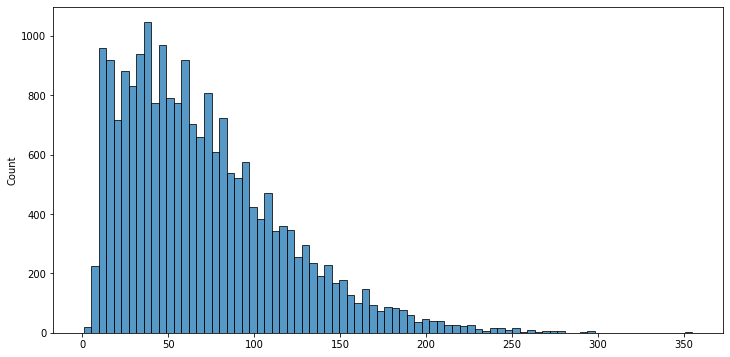

In [6]:
#  построим расределения по просмотрам
sim_views = rng.choice(a=views_distribution.views, size=20998, replace=True, p=views_distribution.p)
plt.figure(figsize=(12, 6))
sns.histplot(sim_views)

Видна явная ассиметрия. 

<Axes: ylabel='Count'>

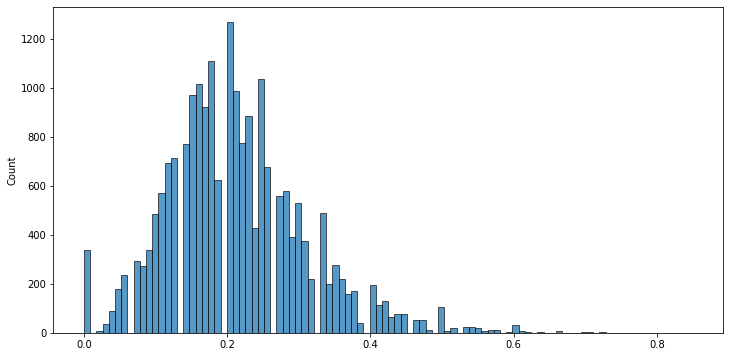

In [7]:
sim_ctr = rng.choice(a=ctr_distribution.ctr, size = 20998, replace=True, p=ctr_distribution.p)
plt.figure(figsize=(12, 6))
sns.histplot(sim_ctr)

CTR выглядят разреженными, чего стоило ожидать - ведь мы фактически округлили непрерывную величину и сэмплировали эти округлённые значения, а любые промежуточные значения генерироваться не будут.

<Axes: ylabel='Count'>

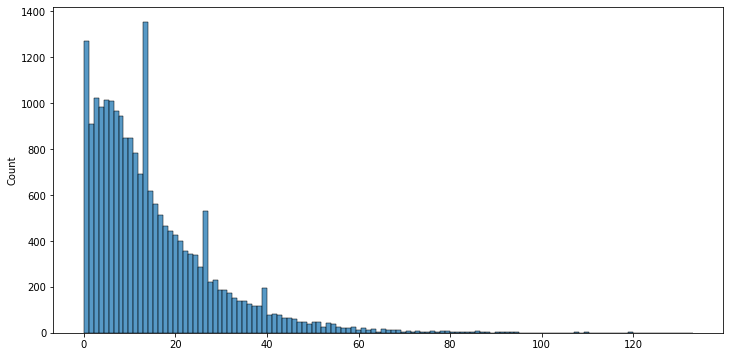

In [8]:
sim_clicks = rng.binomial(n=sim_views.astype("int64"), p=sim_ctr)
plt.figure(figsize=(12, 6))
sns.histplot(sim_clicks)

График лайков так же получился ассиметричным

Прежде чем мы будем симулировать АБ-тестирование и считать мощности, давайте попробуем сделать искусственный АА-тест. Убедимся, что доля ложноположительных результатов (False Positive Rate, FPR) примерно равно значению альфа (0.05).

In [9]:
#функция для расчёта FPR

def fpr_calc(sample_size, views_df, ctr_df, nsim=1000):
    """
    Считает FPR для t-теста при заданных параметрах распределения
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем FPR
    return np.mean(np.array(pvalues) < 0.05)

In [10]:
fpr_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000)

100%|██████████| 20000/20000 [04:34<00:00, 72.91it/s]


0.0499

Результат получился близким к ожиданию

## Задание1. Увеличение числа просмотров на 1-2 с 90%-ой вероятностью для пользователей с числом просмотров >=50

Давайте первым делом посмотрим на то, как такой эффект реализуется в нашей симуляции. Начнём с самого главного.

Здесь мы создаём последовательность из 1 и 2, в соотношении примерно 50/50. Фактически мы генерируем 0 и 1 с вероятностью в 50%, а потом добавляем к ним всем 1.

In [11]:
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [12]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=50, nsim=20000)

100%|██████████| 20000/20000 [04:50<00:00, 68.89it/s]


0.2558

Мощность где-то в районе 25%. Это низкое значение.

## 2. Увеличение числа просмотров на 1-2 с 90%-ой вероятностью для пользователей с числом просмотров >=30

In [13]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [04:49<00:00, 69.00it/s]


0.4161

Теперь у нас мощность где-то около 41.6% - то есть мы выиграли где-то 16% дополнительной мощности. Это всё ещё очень мало. 

## 3. Увеличиваем длительность эксперимента до 2 недель

In [14]:
#  сколько пользователей было в АА-тесте и АВ-тесте
q = """
SELECT uniqExact(user_id)
FROM simulator_20241120.feed_actions
WHERE toDate(time) between '2024-10-18' and '2024-10-31'

"""

n_sample = ph.read_clickhouse(q, connection=connection)
n = int(n_sample.values[0,0])
print(f'Всего при тесте было {n} пользователей.\n'
      f'При равной разбивке в группу попадет {int(n/2)} пользователей')

Всего при тесте было 61182 пользователей.
При равной разбивке в группу попадет 30591 пользователей


In [18]:
power_calc(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [07:00<00:00, 47.52it/s]


0.56415

Мощность 56%. Все еще не хватает до 80%

## 4. Считаем только пользователей с числом просмотров >=30

In [16]:
def power_calc_masked(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта + отсекает пользователей ниже нужного порога
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #маска для отсеивания лишних пользователей
        mask_A = group_A_views>=threshold
        mask_B = group_B_views>=threshold

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A[mask_A], clicks_B[mask_B], equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [17]:
power_calc_masked(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [07:09<00:00, 46.54it/s]


0.64935

Мощность равна 65%. Нам так и не удалось добиться 80%. 

**Вывод:** 